In [1]:
import numpy as np                        # Math
import scipy.stats                        # Statistics
from matplotlib import pyplot as plt      # Plots

Read the file

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
T90=np.array(data[6],dtype=float)
T90_err=np.array(data[7],dtype=float)
fluence = np.array(data[9],dtype=float)

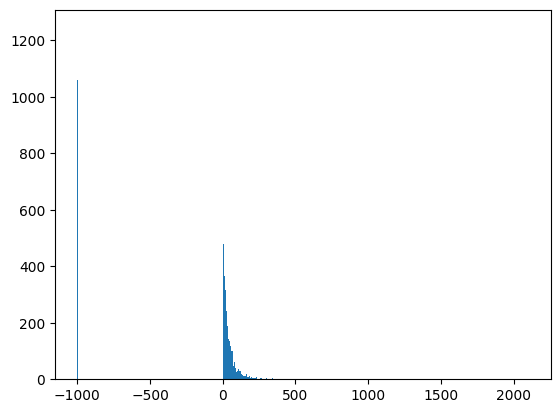

In [5]:
nbins = 1000
plt.hist(T90, bins=nbins, color=None, label=None)
#plt.xlim(-10, 400)
plt.show()

In [6]:
mask = (T90 > 0) & (fluence > 0)
T90_filt = T90[mask]
fluence_filt = fluence[mask]

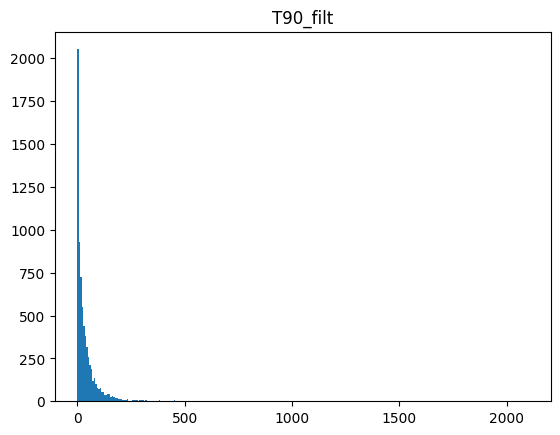

In [7]:
nbins = 300
plt.hist(T90_filt, bins=nbins, color=None, label=None)
plt.title('T90_filt')
plt.show()

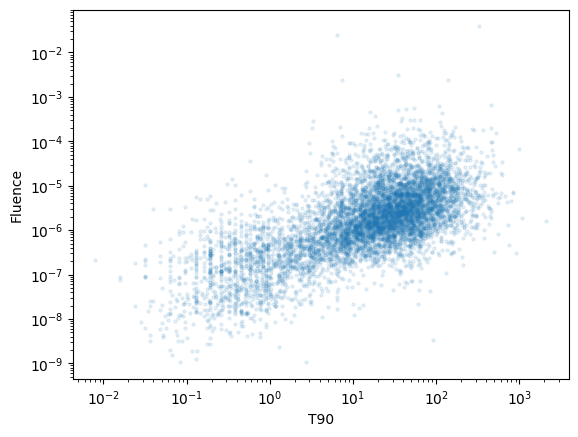

In [8]:
plt.scatter(T90_filt, fluence_filt, s = 5, alpha = 0.1)
plt.xlabel('T90')
plt.ylabel('Fluence')
plt.loglog()
plt.show()

Noto che la bimodalità si osserva in scala logaritmica, infatti:

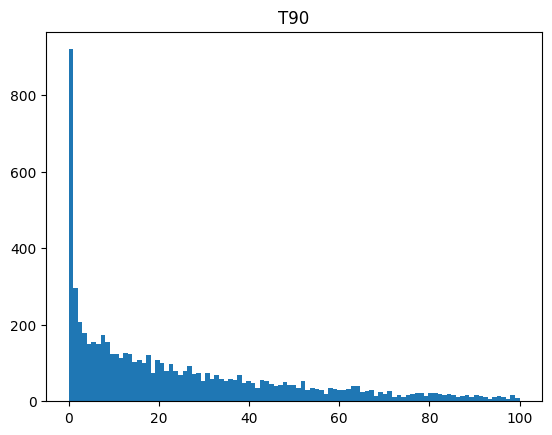

In [9]:
plt.hist(T90_filt, bins= np.linspace(0,100,100))
plt.title('T90')
plt.show()

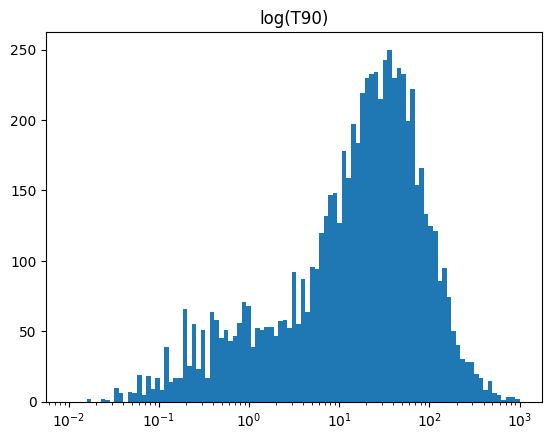

In [10]:
plt.hist(T90_filt, bins= np.logspace(-2,3,100))
plt.title('log(T90)')
plt.semilogx()
plt.show()

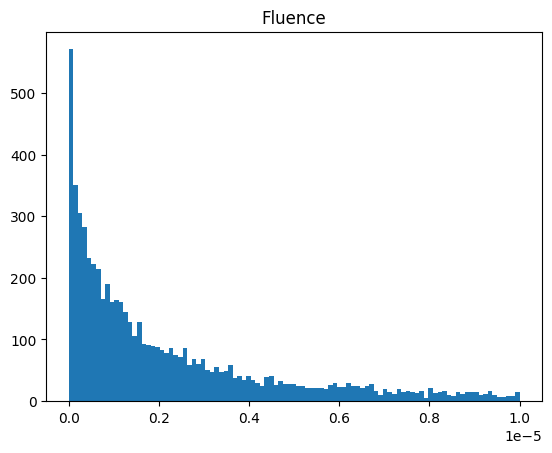

In [11]:
plt.hist(fluence_filt, bins= np.linspace(0,1e-5,100))
plt.title('Fluence')
plt.show()

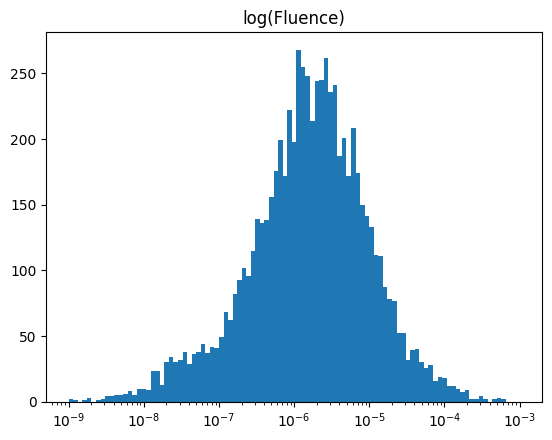

In [12]:
plt.hist(fluence_filt, bins= np.logspace(-9, -3, 100))
plt.title('log(Fluence)')
plt.semilogx()
plt.show()

The two mode are easier to distinguish if we work with T90

### Fit a KDE

In [13]:
lT90 = np.log10(T90_filt)[:,np.newaxis]
lflu = np.log10(fluence_filt)[:,np.newaxis]

Find best bandwith

#Execute this cell to determine the bandwidth
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

bwrange = np.linspace(0.1,1.0, 20) # Test 20 bandwidths from 0.1 to 1.0
#print(bwrange)
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(lT90) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

Fit a KDE

In [14]:
from sklearn.neighbors import KernelDensity
h_opt =  0.15 # from previous cell, just in case I need to rerun it
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt).fit(lT90)

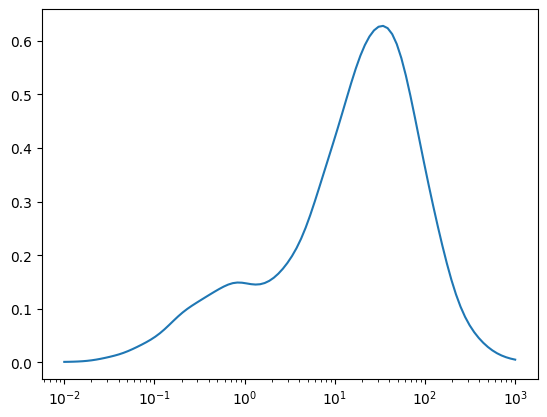

In [15]:
xgrid=np.logspace(-2,3,100)
ygrid = np.exp(kde.score_samples(np.log10(xgrid)[:,np.newaxis]))

plt.plot(xgrid,ygrid)
plt.semilogx();

### Kmeans

#### 1D

In [16]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

X = lT90
#print(X)

clf = KMeans(n_clusters=2, n_init='auto') #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points
inertia = clf.inertia_
print('Sum of squared distances of samples to their closest cluster center (weighted): ' + str(inertia))
print('')
print('Number of points in cluster 0: ' + str(np.count_nonzero(labels == 0)))
print('Number of points in cluster 1: ' + str(np.count_nonzero(labels == 1)))
print('')
print(centers)

Sum of squared distances of samples to their closest cluster center (weighted): 1501.2879181227622

Number of points in cluster 0: 5403
Number of points in cluster 1: 1834

[[ 1.52324625]
 [-0.03340046]]


Find the edge

In [17]:
edge = np.mean( [ max(lT90[labels==0]), min(lT90[labels==1]) ])
print(edge)

0.6126546408629314


Now let's check where the two centers and the edge are positioned

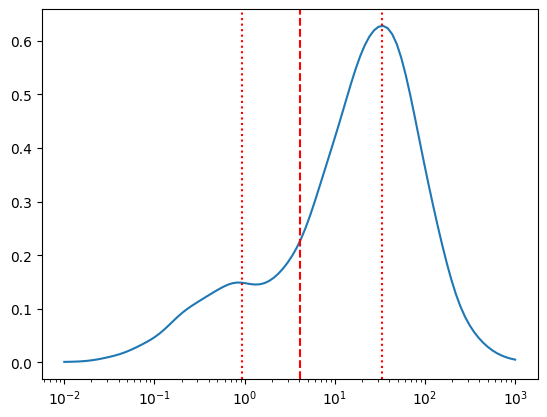

In [18]:
centers_plot = 10**centers
edge_plot = 10**edge

plt.plot(xgrid,ygrid)
plt.semilogx()

for v in centers_plot:
    plt.axvline(v, c='red',ls='dotted')
    
plt.axvline(edge_plot, c='red', ls='dashed')

plt.show()

Plot in 2D

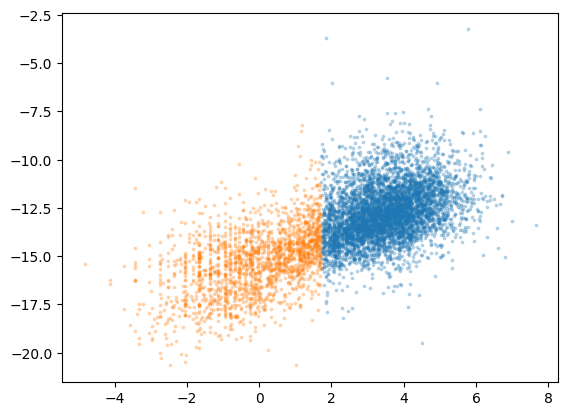

In [19]:
X = np.array([np.log(T90_filt), np.log(fluence_filt)]).T

# plot the data color-coded by cluster id
colors = ['C0', 'C1']
for ii in range(2):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],s = 3, alpha=0.25, label = 'C'+str(ii))

#### 1D gaussian

CHECK WITH SOLUTION

#### 2D

Sum of squared distances of samples to their closest cluster center (weighted): 22440.864752209694

Number of points in cluster 0: 1954
Number of points in cluster 1: 5283



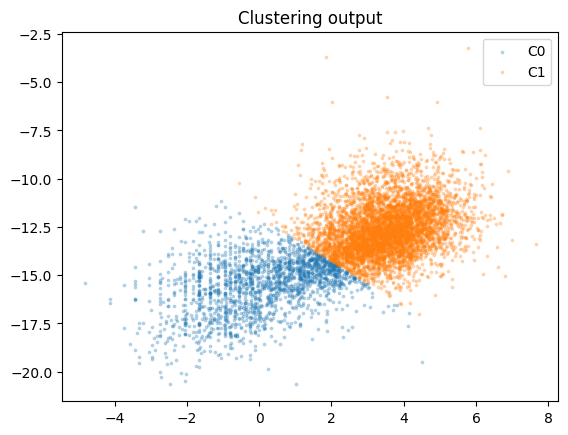

In [20]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

X = np.array([np.log(T90_filt), np.log(fluence_filt)]).T
#print(X)

clf = KMeans(n_clusters=2, n_init='auto') #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points
inertia = clf.inertia_
print('Sum of squared distances of samples to their closest cluster center (weighted): ' + str(inertia))
print('')
print('Number of points in cluster 0: ' + str(np.count_nonzero(labels == 0)))
print('Number of points in cluster 1: ' + str(np.count_nonzero(labels == 1)))
print('')

# plot the data color-coded by cluster id
colors = ['C0', 'C1']
for ii in range(2):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],s = 3, alpha=0.25, label = 'C'+str(ii))

# To get some information on these try:
# kmeans?
# help(clf)
plt.legend()
plt.title('Clustering output');

In [21]:
#KMeans?

### Mean-shift

In [22]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
bandwidth = 0.5
#bandwidth = estimate_bandwidth(X_reduced) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(X))

MeanShift(bandwidth=0.5, bin_seeding=True, cluster_all=False)

In [23]:
#MeanShift?

[-1  0  1  2  3  4  5  6  7  8  9 10 11]
0.5
number of estimated clusters : 12


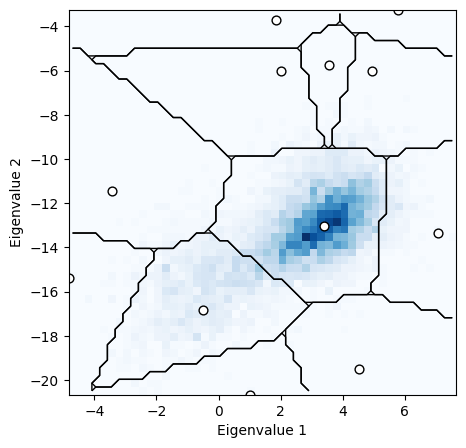

In [24]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()